# State Reconstruction after two-qubit channel application

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator


import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

tf.debugging.set_log_device_placement(False)

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [6]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [7]:
#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [8]:
#function which returns density matrix from bloch components
def rho_from_coeffs(coeffs):
    rho = 0.25 * np.sum([c * p for c,p in zip(coeffs, pauli_basis2q)], axis=0)
    return rho

In [9]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]


def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   return fidelity 

In [10]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) 
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

In [30]:
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

## Noise Model 

In [11]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [12]:
#CORRELATED TWO-QUBIT AMPLITUDE DAMPING CHANNEL

def corr_twoq_ad(num_qubits, rho, eta, mu):
    
    E_0 = np.array([[1, 0], [0, np.sqrt(eta)]])
    E_1 = np.array([[0, np.sqrt(1 - eta)], [0, 0]])
    
    A_0 = np.kron(E_0, E_0)
    A_1 = np.kron(E_0, E_1)
    A_2 = np.kron(E_1, E_0)
    A_3 = np.kron(E_1, E_1)


    B_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.sqrt(eta)]])
    B_1 = np.array([[0, 0, 0, np.sqrt(1 - eta)], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

    N_0 = sum_element(rho, A_0) + sum_element(rho, A_1) + sum_element(rho, A_2) + sum_element(rho, A_3)
    N_1 = sum_element(rho, B_0) + sum_element(rho, B_1)

    noisy_rho = (1 - mu) * N_0 + mu * N_1
    return noisy_rho

## Training the Algorithm

In [13]:
data = generate_Haar_data(2, 10000) 
density_matrix_noise_free = [*map(get_density_matrix, data)] 
bloch_vectors_noise_free = [*map(bloch_coeffs, density_matrix_noise_free)]

In [15]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = corr_twoq_ad(2, density_matrix_noise_free[i], 0.2, 0.3)
    density_matrix_with_noise.append(single_data_with_noise)

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES WITH NOISE
print("Density matrix with noise type:", density_matrix_with_noise[0].dtype)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(bloch_coeffs, density_matrix_with_noise)]
print("Bloch vector with noise type:", bloch_vectors_with_noise[0].dtype)

Density matrix with noise type: complex128
Bloch vector with noise type: complex128


## <font color='red'>MSE</font>

In [78]:
x_train_list = bloch_vectors_with_noise[:800]
y_train_list = bloch_vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[800:900]
y_val_list = bloch_vectors_noise_free[800:900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[900:1000]
y_test_list = bloch_vectors_noise_free[900:1000]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [79]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  #tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [80]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [81]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=900)

Epoch 1/900
8/8 [==============================] - 1s 29ms/step - loss: 0.2016 - val_loss: 0.1920
Epoch 2/900
8/8 [==============================] - 0s 8ms/step - loss: 0.1920 - val_loss: 0.1853
Epoch 3/900
8/8 [==============================] - 0s 7ms/step - loss: 0.1851 - val_loss: 0.1797
Epoch 4/900
8/8 [==============================] - 0s 8ms/step - loss: 0.1794 - val_loss: 0.1745
Epoch 5/900
8/8 [==============================] - 0s 7ms/step - loss: 0.1742 - val_loss: 0.1697
Epoch 6/900
8/8 [==============================] - 0s 8ms/step - loss: 0.1691 - val_loss: 0.1648
Epoch 7/900
8/8 [==============================] - 0s 8ms/step - loss: 0.1641 - val_loss: 0.1598
Epoch 8/900
8/8 [==============================] - 0s 9ms/step - loss: 0.1589 - val_loss: 0.1546
Epoch 9/900
8/8 [==============================] - 0s 8ms/step - loss: 0.1535 - val_loss: 0.1491
Epoch 10/900
8/8 [==============================] - 0s 9ms/step - loss: 0.1480 - val_loss: 0.1435
Epoch 11/900
8/8 [==========

8/8 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 85/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 86/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0076
Epoch 87/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 88/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0074
Epoch 89/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0074
Epoch 90/900
8/8 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0072
Epoch 91/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 92/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0058 - val_loss: 0.0070
Epoch 93/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 94/900
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 168/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 169/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 170/900
8/8 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 171/900
8/8 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 172/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 173/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 174/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 175/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 176/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 177/900
8/8 [===

8/8 [==============================] - 0s 10ms/step - loss: 4.3948e-04 - val_loss: 8.4312e-04
Epoch 247/900
8/8 [==============================] - 0s 9ms/step - loss: 4.4535e-04 - val_loss: 8.5498e-04
Epoch 248/900
8/8 [==============================] - 0s 9ms/step - loss: 4.4793e-04 - val_loss: 8.4984e-04
Epoch 249/900
8/8 [==============================] - 0s 9ms/step - loss: 4.4340e-04 - val_loss: 8.3409e-04
Epoch 250/900
8/8 [==============================] - 0s 9ms/step - loss: 4.2659e-04 - val_loss: 8.1218e-04
Epoch 251/900
8/8 [==============================] - 0s 9ms/step - loss: 4.3330e-04 - val_loss: 8.3173e-04
Epoch 252/900
8/8 [==============================] - 0s 9ms/step - loss: 4.3418e-04 - val_loss: 8.0207e-04
Epoch 253/900
8/8 [==============================] - 0s 9ms/step - loss: 4.0521e-04 - val_loss: 7.6904e-04
Epoch 254/900
8/8 [==============================] - 0s 8ms/step - loss: 3.9621e-04 - val_loss: 7.6544e-04
Epoch 255/900
8/8 [==============================]

8/8 [==============================] - 0s 8ms/step - loss: 2.2595e-04 - val_loss: 4.0753e-04
Epoch 323/900
8/8 [==============================] - 0s 8ms/step - loss: 2.2064e-04 - val_loss: 4.0356e-04
Epoch 324/900
8/8 [==============================] - 0s 12ms/step - loss: 2.2057e-04 - val_loss: 4.0366e-04
Epoch 325/900
8/8 [==============================] - 0s 8ms/step - loss: 2.1856e-04 - val_loss: 3.9760e-04
Epoch 326/900
8/8 [==============================] - 0s 8ms/step - loss: 2.1529e-04 - val_loss: 3.9802e-04
Epoch 327/900
8/8 [==============================] - 0s 7ms/step - loss: 2.1613e-04 - val_loss: 3.8888e-04
Epoch 328/900
8/8 [==============================] - 0s 7ms/step - loss: 2.1957e-04 - val_loss: 3.8708e-04
Epoch 329/900
8/8 [==============================] - 0s 7ms/step - loss: 2.1850e-04 - val_loss: 4.3450e-04
Epoch 330/900
8/8 [==============================] - 0s 7ms/step - loss: 2.2316e-04 - val_loss: 3.7663e-04
Epoch 331/900
8/8 [==============================]

8/8 [==============================] - 0s 8ms/step - loss: 1.3891e-04 - val_loss: 2.5746e-04
Epoch 399/900
8/8 [==============================] - 0s 7ms/step - loss: 1.3446e-04 - val_loss: 2.4592e-04
Epoch 400/900
8/8 [==============================] - 0s 7ms/step - loss: 1.3646e-04 - val_loss: 2.4954e-04
Epoch 401/900
8/8 [==============================] - 0s 7ms/step - loss: 1.3221e-04 - val_loss: 2.6684e-04
Epoch 402/900
8/8 [==============================] - 0s 7ms/step - loss: 1.3793e-04 - val_loss: 2.4769e-04
Epoch 403/900
8/8 [==============================] - 0s 7ms/step - loss: 1.3643e-04 - val_loss: 2.5235e-04
Epoch 404/900
8/8 [==============================] - 0s 8ms/step - loss: 1.3042e-04 - val_loss: 2.4458e-04
Epoch 405/900
8/8 [==============================] - 0s 8ms/step - loss: 1.3393e-04 - val_loss: 2.4349e-04
Epoch 406/900
8/8 [==============================] - 0s 7ms/step - loss: 1.2973e-04 - val_loss: 2.4494e-04
Epoch 407/900
8/8 [==============================] 

8/8 [==============================] - 0s 8ms/step - loss: 1.0565e-04 - val_loss: 1.8750e-04
Epoch 475/900
8/8 [==============================] - 0s 8ms/step - loss: 1.2358e-04 - val_loss: 2.2498e-04
Epoch 476/900
8/8 [==============================] - 0s 7ms/step - loss: 1.1942e-04 - val_loss: 1.9521e-04
Epoch 477/900
8/8 [==============================] - 0s 7ms/step - loss: 1.1008e-04 - val_loss: 2.1374e-04
Epoch 478/900
8/8 [==============================] - 0s 9ms/step - loss: 9.7780e-05 - val_loss: 1.7801e-04
Epoch 479/900
8/8 [==============================] - 0s 7ms/step - loss: 9.8261e-05 - val_loss: 1.9034e-04
Epoch 480/900
8/8 [==============================] - 0s 7ms/step - loss: 9.3842e-05 - val_loss: 1.7887e-04
Epoch 481/900
8/8 [==============================] - 0s 7ms/step - loss: 9.2716e-05 - val_loss: 1.8546e-04
Epoch 482/900
8/8 [==============================] - 0s 7ms/step - loss: 9.0538e-05 - val_loss: 1.7387e-04
Epoch 483/900
8/8 [==============================] 

8/8 [==============================] - 0s 7ms/step - loss: 7.6033e-05 - val_loss: 1.5756e-04
Epoch 551/900
8/8 [==============================] - 0s 7ms/step - loss: 7.6340e-05 - val_loss: 1.4980e-04
Epoch 552/900
8/8 [==============================] - 0s 7ms/step - loss: 7.2087e-05 - val_loss: 1.5855e-04
Epoch 553/900
8/8 [==============================] - 0s 7ms/step - loss: 7.4407e-05 - val_loss: 1.5358e-04
Epoch 554/900
8/8 [==============================] - 0s 8ms/step - loss: 6.9759e-05 - val_loss: 1.4451e-04
Epoch 555/900
8/8 [==============================] - 0s 7ms/step - loss: 7.0474e-05 - val_loss: 1.4721e-04
Epoch 556/900
8/8 [==============================] - 0s 8ms/step - loss: 6.8151e-05 - val_loss: 1.4946e-04
Epoch 557/900
8/8 [==============================] - 0s 7ms/step - loss: 7.1138e-05 - val_loss: 1.5195e-04
Epoch 558/900
8/8 [==============================] - 0s 9ms/step - loss: 7.4278e-05 - val_loss: 1.4509e-04
Epoch 559/900
8/8 [==============================] 

8/8 [==============================] - 0s 7ms/step - loss: 6.4140e-05 - val_loss: 1.3385e-04
Epoch 627/900
8/8 [==============================] - 0s 7ms/step - loss: 6.6457e-05 - val_loss: 1.5351e-04
Epoch 628/900
8/8 [==============================] - 0s 8ms/step - loss: 6.3322e-05 - val_loss: 1.3777e-04
Epoch 629/900
8/8 [==============================] - 0s 8ms/step - loss: 6.1382e-05 - val_loss: 1.2969e-04
Epoch 630/900
8/8 [==============================] - 0s 7ms/step - loss: 6.3824e-05 - val_loss: 1.3864e-04
Epoch 631/900
8/8 [==============================] - 0s 7ms/step - loss: 5.7443e-05 - val_loss: 1.2398e-04
Epoch 632/900
8/8 [==============================] - 0s 8ms/step - loss: 5.7313e-05 - val_loss: 1.2888e-04
Epoch 633/900
8/8 [==============================] - 0s 7ms/step - loss: 5.2871e-05 - val_loss: 1.2811e-04
Epoch 634/900
8/8 [==============================] - 0s 7ms/step - loss: 5.6381e-05 - val_loss: 1.2894e-04
Epoch 635/900
8/8 [==============================] 

8/8 [==============================] - 0s 8ms/step - loss: 4.8046e-05 - val_loss: 1.2068e-04
Epoch 703/900
8/8 [==============================] - 0s 8ms/step - loss: 4.6026e-05 - val_loss: 1.1523e-04
Epoch 704/900
8/8 [==============================] - 0s 7ms/step - loss: 4.5219e-05 - val_loss: 1.1231e-04
Epoch 705/900
8/8 [==============================] - 0s 7ms/step - loss: 5.0182e-05 - val_loss: 1.2140e-04
Epoch 706/900
8/8 [==============================] - 0s 8ms/step - loss: 5.4491e-05 - val_loss: 1.2245e-04
Epoch 707/900
8/8 [==============================] - 0s 7ms/step - loss: 4.7458e-05 - val_loss: 1.1782e-04
Epoch 708/900
8/8 [==============================] - 0s 7ms/step - loss: 4.8828e-05 - val_loss: 1.2535e-04
Epoch 709/900
8/8 [==============================] - 0s 8ms/step - loss: 4.9428e-05 - val_loss: 1.2070e-04
Epoch 710/900
8/8 [==============================] - 0s 7ms/step - loss: 5.0469e-05 - val_loss: 1.1091e-04
Epoch 711/900
8/8 [==============================] 

8/8 [==============================] - 0s 8ms/step - loss: 3.8687e-05 - val_loss: 1.1114e-04
Epoch 779/900
8/8 [==============================] - 0s 7ms/step - loss: 3.9495e-05 - val_loss: 1.0727e-04
Epoch 780/900
8/8 [==============================] - 0s 8ms/step - loss: 3.8508e-05 - val_loss: 1.0938e-04
Epoch 781/900
8/8 [==============================] - 0s 7ms/step - loss: 3.9802e-05 - val_loss: 1.0525e-04
Epoch 782/900
8/8 [==============================] - 0s 7ms/step - loss: 4.3221e-05 - val_loss: 1.0828e-04
Epoch 783/900
8/8 [==============================] - 0s 10ms/step - loss: 3.8780e-05 - val_loss: 1.1245e-04
Epoch 784/900
8/8 [==============================] - 0s 8ms/step - loss: 4.1125e-05 - val_loss: 1.0076e-04
Epoch 785/900
8/8 [==============================] - 0s 7ms/step - loss: 4.1485e-05 - val_loss: 1.0749e-04
Epoch 786/900
8/8 [==============================] - 0s 7ms/step - loss: 3.9675e-05 - val_loss: 1.2314e-04
Epoch 787/900
8/8 [==============================]

8/8 [==============================] - 0s 8ms/step - loss: 3.4880e-05 - val_loss: 9.7629e-05
Epoch 855/900
8/8 [==============================] - 0s 8ms/step - loss: 3.7749e-05 - val_loss: 9.8594e-05
Epoch 856/900
8/8 [==============================] - 0s 8ms/step - loss: 3.6705e-05 - val_loss: 1.0678e-04
Epoch 857/900
8/8 [==============================] - 0s 8ms/step - loss: 3.6279e-05 - val_loss: 9.7378e-05
Epoch 858/900
8/8 [==============================] - 0s 8ms/step - loss: 3.6311e-05 - val_loss: 1.0093e-04
Epoch 859/900
8/8 [==============================] - 0s 8ms/step - loss: 3.1649e-05 - val_loss: 1.0220e-04
Epoch 860/900
8/8 [==============================] - 0s 9ms/step - loss: 3.2395e-05 - val_loss: 9.5113e-05
Epoch 861/900
8/8 [==============================] - 0s 8ms/step - loss: 3.7119e-05 - val_loss: 1.0214e-04
Epoch 862/900
8/8 [==============================] - 0s 8ms/step - loss: 4.7074e-05 - val_loss: 9.8839e-05
Epoch 863/900
8/8 [==============================] 

In [82]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 1.0525e-04 - 158ms/epoch - 40ms/step


In [83]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_mse = tf.math.reduce_mean(fid)
print(fid_mse)

tf.Tensor((0.9986389-4.9113623e-05j), shape=(), dtype=complex64)


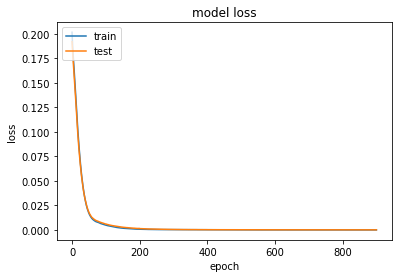

In [84]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>Training the Algorithm (INF)</font>

In [71]:
x_train_list = bloch_vectors_with_noise[:800]
y_train_list = bloch_vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[9000:9500]
y_val_list = bloch_vectors_noise_free[9000:9500]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[9500:]
y_test_list = bloch_vectors_noise_free[9500:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [72]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [73]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0001)
model.compile(optimizer=adam_opt,
              loss=inf)

In [74]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=900)

Epoch 1/900
8/8 [==============================] - 1s 28ms/step - loss: 0.7201 - val_loss: 0.7081
Epoch 2/900
8/8 [==============================] - 0s 9ms/step - loss: 0.7066 - val_loss: 0.6948
Epoch 3/900
8/8 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6808
Epoch 4/900
8/8 [==============================] - 0s 9ms/step - loss: 0.6786 - val_loss: 0.6660
Epoch 5/900
8/8 [==============================] - 0s 8ms/step - loss: 0.6632 - val_loss: 0.6503
Epoch 6/900
8/8 [==============================] - 0s 8ms/step - loss: 0.6469 - val_loss: 0.6335
Epoch 7/900
8/8 [==============================] - 0s 8ms/step - loss: 0.6296 - val_loss: 0.6152
Epoch 8/900
8/8 [==============================] - 0s 9ms/step - loss: 0.6107 - val_loss: 0.5955
Epoch 9/900
8/8 [==============================] - 0s 9ms/step - loss: 0.5905 - val_loss: 0.5744
Epoch 10/900
8/8 [==============================] - 0s 8ms/step - loss: 0.5691 - val_loss: 0.5526
Epoch 11/900
8/8 [==========

8/8 [==============================] - 0s 8ms/step - loss: 0.0798 - val_loss: 0.0893
Epoch 85/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0785 - val_loss: 0.0881
Epoch 86/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0772 - val_loss: 0.0867
Epoch 87/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0760 - val_loss: 0.0853
Epoch 88/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0747 - val_loss: 0.0842
Epoch 89/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0735 - val_loss: 0.0829
Epoch 90/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0723 - val_loss: 0.0815
Epoch 91/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0711 - val_loss: 0.0804
Epoch 92/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0699 - val_loss: 0.0793
Epoch 93/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0688 - val_loss: 0.0780
Epoch 94/900
8/8 [===============

Epoch 167/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0262 - val_loss: 0.0333
Epoch 168/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0259 - val_loss: 0.0330
Epoch 169/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0257 - val_loss: 0.0327
Epoch 170/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0254 - val_loss: 0.0324
Epoch 171/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0252 - val_loss: 0.0321
Epoch 172/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0250 - val_loss: 0.0319
Epoch 173/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - val_loss: 0.0316
Epoch 174/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0245 - val_loss: 0.0314
Epoch 175/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0243 - val_loss: 0.0311
Epoch 176/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0241 - val_loss: 0.0309
Epoch 177/

8/8 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0189
Epoch 250/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0139 - val_loss: 0.0187
Epoch 251/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0138 - val_loss: 0.0186
Epoch 252/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0137 - val_loss: 0.0185
Epoch 253/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0137 - val_loss: 0.0184
Epoch 254/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0183
Epoch 255/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0182
Epoch 256/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0181
Epoch 257/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0180
Epoch 258/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0132 - val_loss: 0.0179
Epoch 259/900
8/8 [=====

Epoch 332/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0116
Epoch 333/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0115
Epoch 334/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0081 - val_loss: 0.0115
Epoch 335/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.0114
Epoch 336/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0113
Epoch 337/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.0113
Epoch 338/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.0112
Epoch 339/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0112
Epoch 340/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0111
Epoch 341/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0077 - val_loss: 0.0110
Epoch 342/

8/8 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0074
Epoch 415/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0074
Epoch 416/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0073
Epoch 417/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 418/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0072
Epoch 419/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0072
Epoch 420/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 421/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 422/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 423/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0070
Epoch 424/900
8/8 [=====

Epoch 497/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 498/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 499/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 500/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 501/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 502/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 503/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 504/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 505/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 506/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 507/

8/8 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 580/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 581/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 582/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 583/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 584/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 585/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 586/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 587/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 588/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 589/900
8/8 [=====

Epoch 662/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 663/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 664/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 665/900
8/8 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 666/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 667/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 668/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 669/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 670/900
8/8 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 671/900
8/8 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 672/

8/8 [==============================] - 0s 8ms/step - loss: 8.3497e-04 - val_loss: 0.0015
Epoch 744/900
8/8 [==============================] - 0s 8ms/step - loss: 8.3393e-04 - val_loss: 0.0015
Epoch 745/900
8/8 [==============================] - 0s 8ms/step - loss: 8.3273e-04 - val_loss: 0.0015
Epoch 746/900
8/8 [==============================] - 0s 8ms/step - loss: 8.4479e-04 - val_loss: 0.0015
Epoch 747/900
8/8 [==============================] - 0s 9ms/step - loss: 8.4109e-04 - val_loss: 0.0015
Epoch 748/900
8/8 [==============================] - 0s 8ms/step - loss: 8.2427e-04 - val_loss: 0.0014
Epoch 749/900
8/8 [==============================] - 0s 8ms/step - loss: 8.1522e-04 - val_loss: 0.0014
Epoch 750/900
8/8 [==============================] - 0s 8ms/step - loss: 8.0654e-04 - val_loss: 0.0014
Epoch 751/900
8/8 [==============================] - 0s 8ms/step - loss: 8.1420e-04 - val_loss: 0.0014
Epoch 752/900
8/8 [==============================] - 0s 9ms/step - loss: 7.9952e-04 - v

8/8 [==============================] - 0s 9ms/step - loss: 5.6251e-04 - val_loss: 9.8268e-04
Epoch 823/900
8/8 [==============================] - 0s 9ms/step - loss: 5.5361e-04 - val_loss: 9.8171e-04
Epoch 824/900
8/8 [==============================] - 0s 8ms/step - loss: 5.5572e-04 - val_loss: 9.8034e-04
Epoch 825/900
8/8 [==============================] - 0s 8ms/step - loss: 5.5302e-04 - val_loss: 9.7630e-04
Epoch 826/900
8/8 [==============================] - 0s 9ms/step - loss: 5.5710e-04 - val_loss: 9.7841e-04
Epoch 827/900
8/8 [==============================] - 0s 8ms/step - loss: 5.5369e-04 - val_loss: 9.8871e-04
Epoch 828/900
8/8 [==============================] - 0s 8ms/step - loss: 5.4895e-04 - val_loss: 9.6147e-04
Epoch 829/900
8/8 [==============================] - 0s 8ms/step - loss: 5.4902e-04 - val_loss: 9.5286e-04
Epoch 830/900
8/8 [==============================] - 0s 9ms/step - loss: 5.4156e-04 - val_loss: 9.5260e-04
Epoch 831/900
8/8 [==============================] 

8/8 [==============================] - 0s 10ms/step - loss: 3.7357e-04 - val_loss: 6.7863e-04
Epoch 899/900
8/8 [==============================] - 0s 8ms/step - loss: 3.7836e-04 - val_loss: 6.7101e-04
Epoch 900/900
8/8 [==============================] - 0s 8ms/step - loss: 3.7378e-04 - val_loss: 6.7730e-04


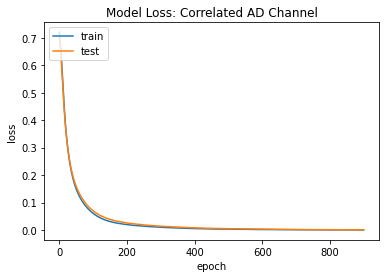

In [75]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Correlated AD Channel')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(0,30)
plt.show()

In [76]:
score = model.evaluate(x_test,  y_test, verbose=2)

16/16 - 0s - loss: 7.1443e-04 - 156ms/epoch - 10ms/step


In [77]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_inf = tf.math.reduce_mean(fid)
print(fid_inf)

tf.Tensor((0.9997236-8.266444e-06j), shape=(), dtype=complex64)
